Wybieramy temat. Może być to temat z pierwszego projektu. Jeśli pozostajemy przy tym 
samym temacie musimy znaleźć zmienną celu. 
2. Dokonujemy eksploracji zbioru. Uzupełniamy braki danych. Dokonujemy wstępnej selekcji 
zmiennych.   
3. Dzielimy zbiór danych na treningowy testowy i w miarę możliwości na walidacyjny. 
4. Tworzymy minimum 3 modele predykcyjne (może być ich więcej) wraz z dostrojeniem 
hiperparametrów. 
5. Porównać i wybrać najlepszy model. 
6. Dokonać ostatecznej oceny wybranego modelu na zbiorze walidacyjnym. 
7. Wskazać uzysk dla firmy / odbiorcy (np. ile pieniędzy z tego będzie miała, jak wdrożenie 
wpłynie na rozpoznawalność przypadków, dla których firma wykona działania prewencyjne 
itd.) 
8. Stworzenie aplikacji wykorzystującej model 
9. Na prezentacji powinna znaleźć się krótka analiza zmiennych, omówienie wyników 
wszystkich zastosowanych technik modelowania i ich porównanie, wybór modelu i przede 
wszystkim wartość dodana jaką niesie za sobą wdrożenie

4. Odejdzie  czy nie odejdzie?  – prognozowanie zjawiska churn wśród Klientów telecom  
• Prognozowanie czy jest zagrożenie, że Klient zrezygnuje z usług firmy 
• Aplikacja dla pracowników informująca o zagrożeniu odejścia Klienta 
• https://www.kaggle.com/blastchar/telco-customer-churn 
 


In [1]:
#Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,3) 
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV,validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Assumptions & Questions: 
# Some features seem ordinal (contract, multiplelines) encoding was done with labelencoder style not dummifier 
# Predicted class is inbalanced 5900 no churn (0) and 1900 churn (1) (churn no churn 1:4 proportions) that is why when using gridsearch we use class_weight
# TotalCharges has quite some outliers do we deal with them via standardscaler,mixmaxscaler
# Some features are strongly interwined (i.e. has internet vs online backup, streaming etc.)
# Models with no hyperparameters are more or less same on all set and set only of correlated features with target (was lookign at positive class precision & recall)

In [2]:
#Import data 
df=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

#During training attempt it turned out TotalCharges has empty strings and cannot be converted to number, let's remove it. 
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
df.dropna(inplace=True)

In [3]:
# Basic data analysis (shape, info, describe,value_counts)
#   Set has 7000k rows and 21 columns, All features are object type except:
#   SeniorCitizen, Tenure, Montlhly Charges, Total Charges. 
#   SeniorCitizen is categorical despite numerical format (i.e. takes only 1 or 0 value)
#   SeniorCitizen, MultipleLines,Contract - seem to be categorical ordinal so we will use proper encoder for them

display(df.info())
display(df.describe())
for col in df.columns:
    print(df[col].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


None

SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7032.000000  7032.000000     7032.000000   7032.000000
mean        0.162400    32.421786       64.798208   2283.300441
std         0.368844    24.545260       30.085974   2266.771362
min         0.000000     1.000000       18.250000     18.800000
25%         0.000000     9.000000       35.587500    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.862500   3794.737500
max         1.000000    72.000000      118.750000   8684.800000

7590-VHVEG    1
0265-PSUAE    1
2956-GGUCQ    1
6008-NAIXK    1
5956-YHHRX    1
             ..
7874-ECPQJ    1
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
3186-AJIEK    1
Name: customerID, Length: 7032, dtype: int64
Male      3549
Female    3483
Name: gender, dtype: int64
0    5890
1    1142
Name: SeniorCitizen, dtype: int64
No     3639
Yes    3393
Name: Partner, dtype: int64
No     4933
Yes    2099
Name: Dependents, dtype: int64
1     613
72    362
2     238
3     200
4     176
     ... 
38     59
28     57
39     56
44     51
36     50
Name: tenure, Length: 72, dtype: int64
Yes    6352
No      680
Name: PhoneService, dtype: int64
No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64
Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64
No                     3497
Yes                    2015
No internet service    1520
Name: OnlineSecurity, dtype: int64
No                     3087
Yes

In [4]:
#Customer ID carries no value in information let's drop it
df.drop('customerID',axis=1,inplace=True)

In [5]:
#split featuers into categorical & numerical
numerical_features=['tenure', 'TotalCharges','MonthlyCharges']

categorical_features=[ 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'Churn']

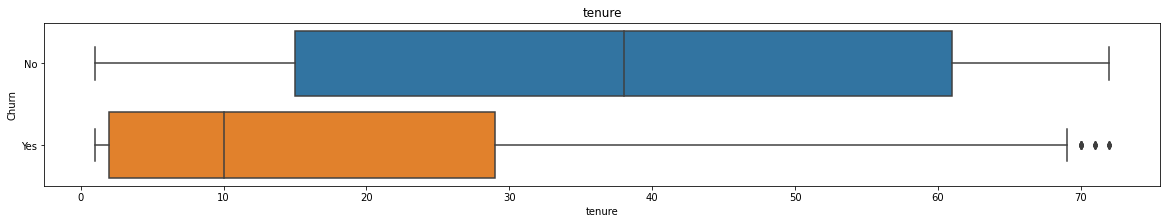

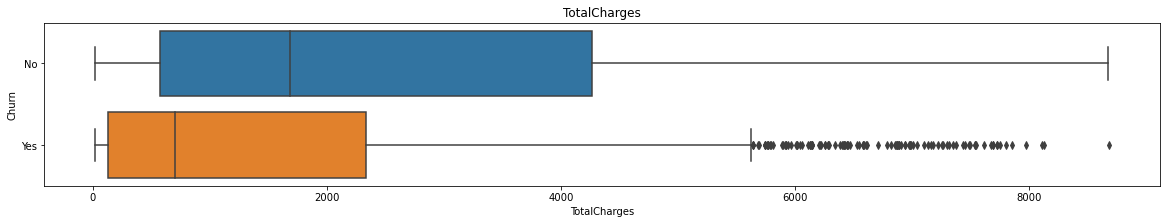

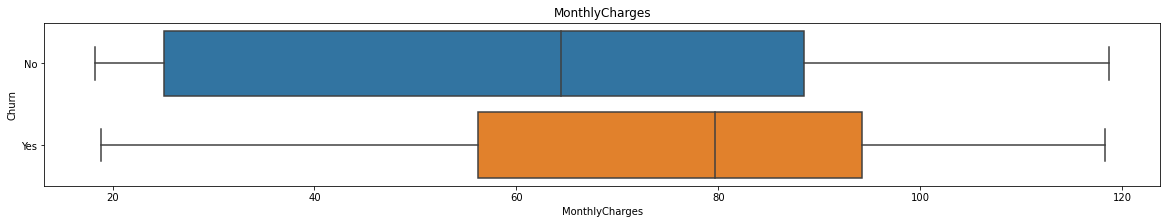

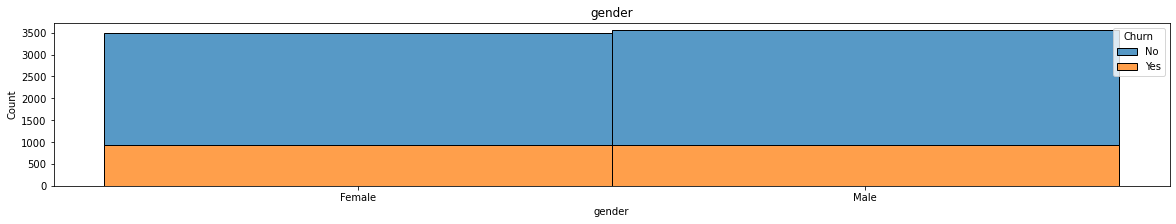

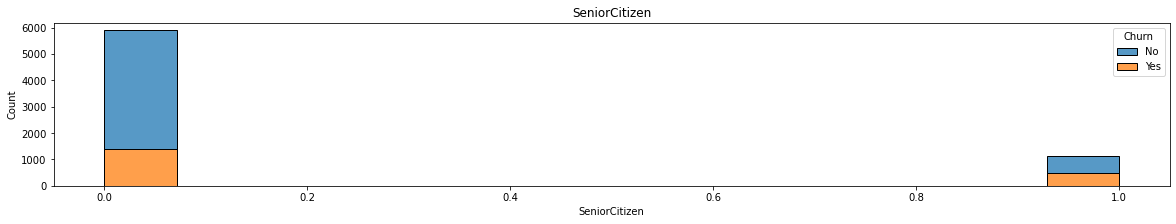

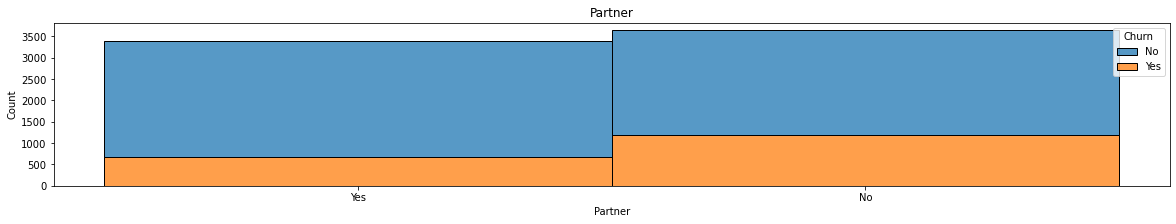

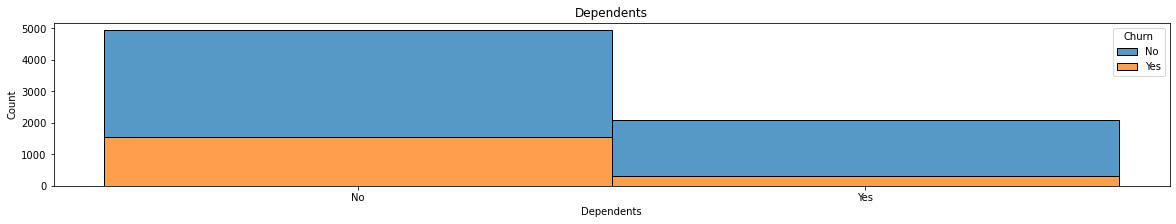

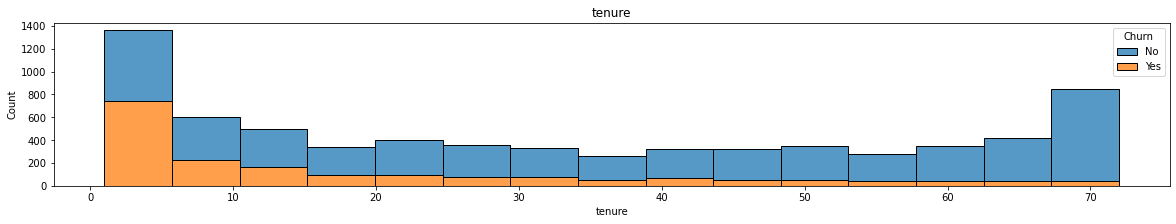

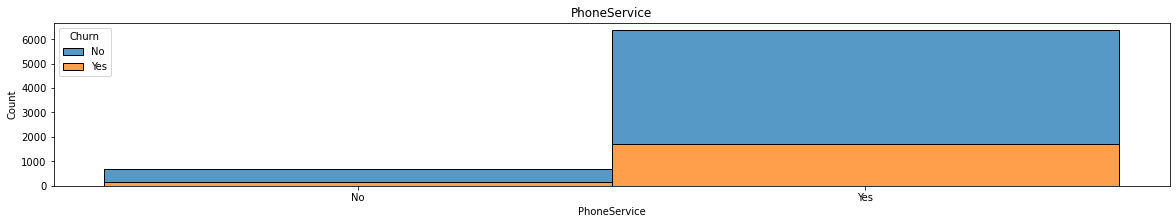

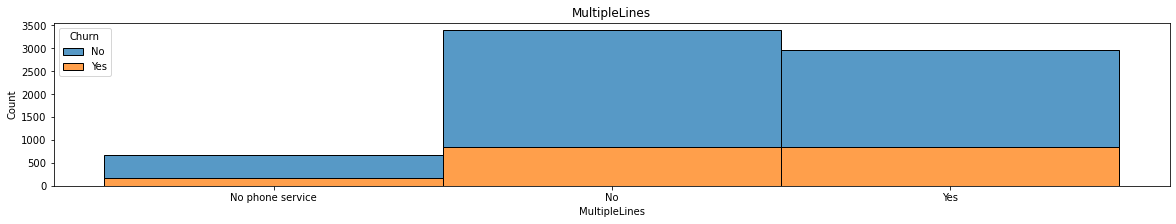

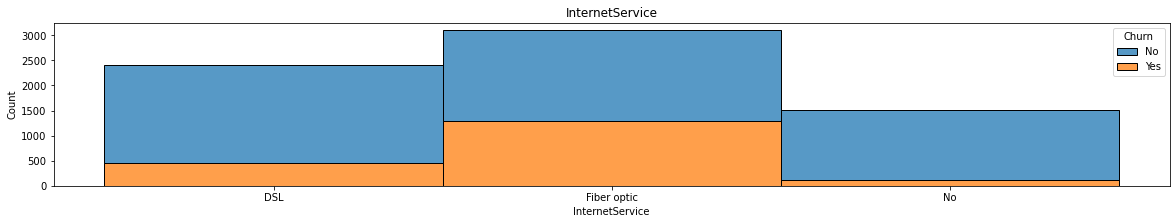

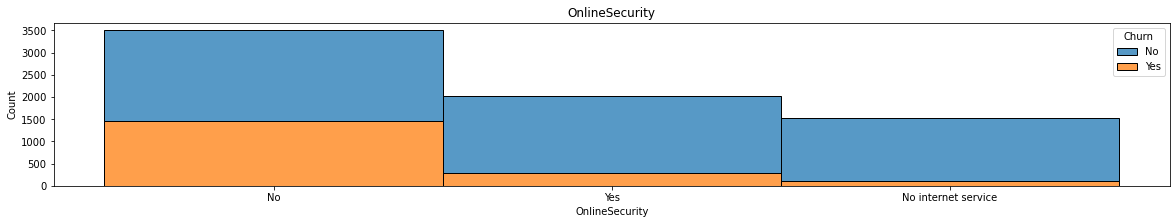

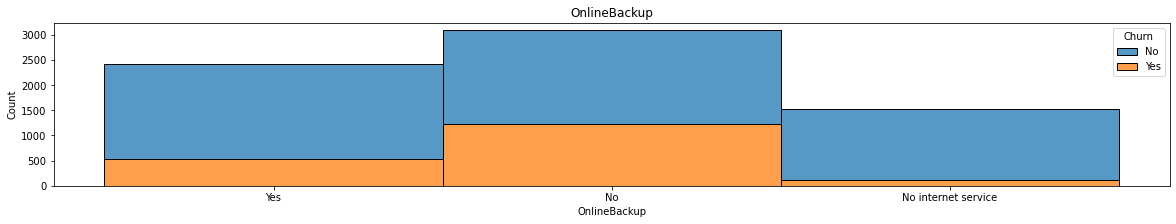

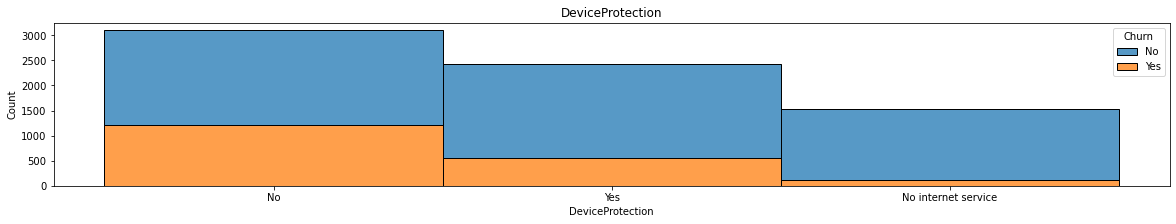

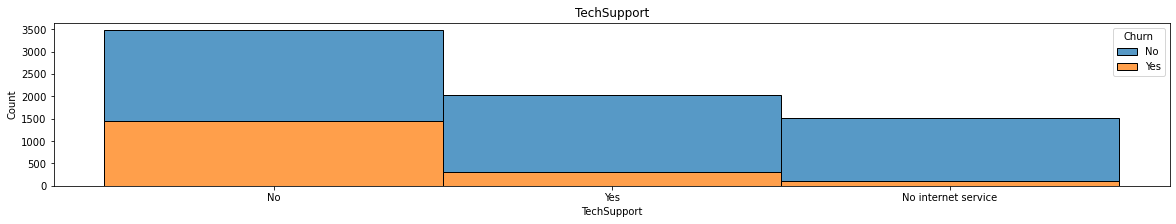

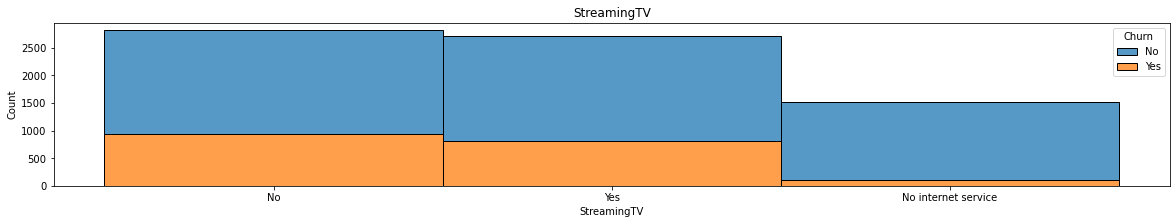

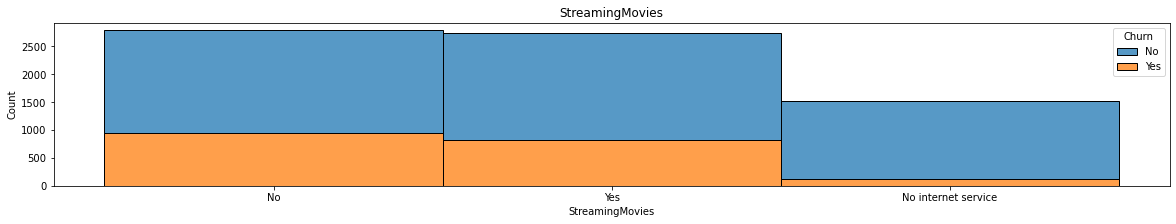

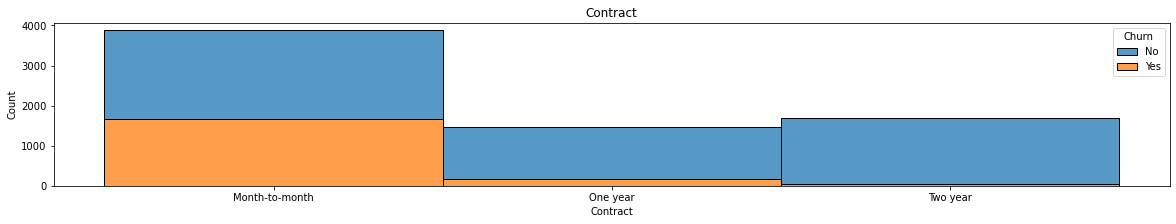

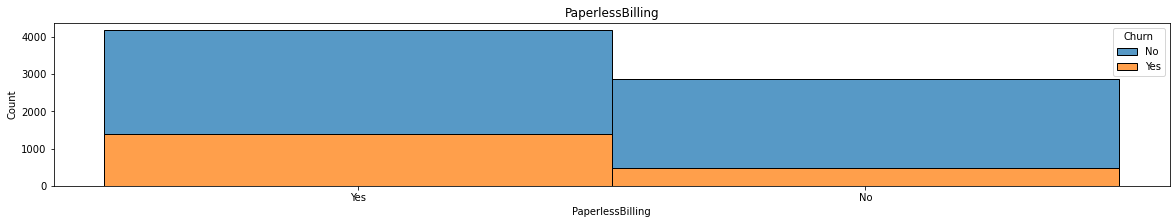

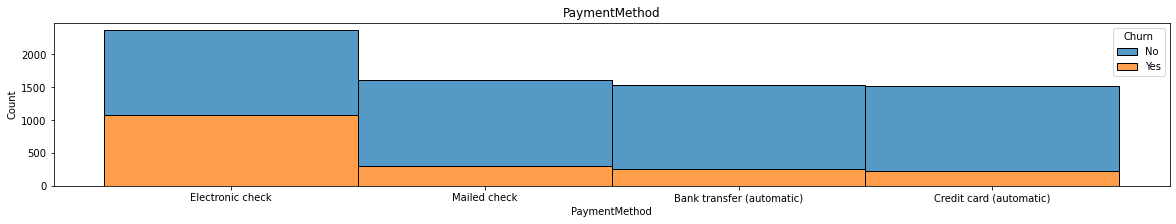

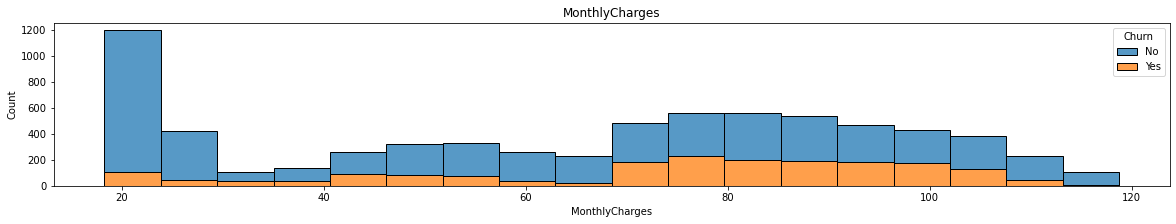

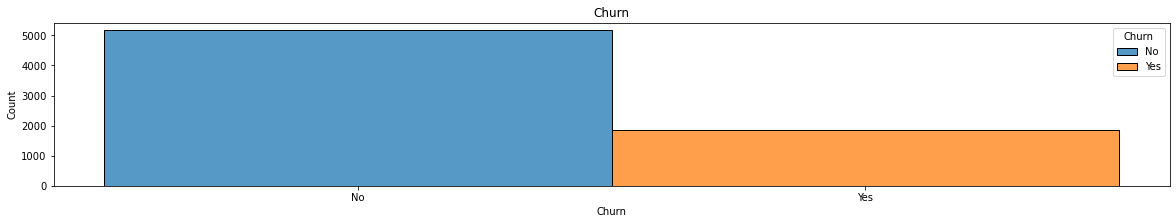

In [6]:
#draw histogram for categorical & boxplot for numerical
#   Tenure, Monthly and Total Charges have corelation with Churn i.e. those hwo left last motnh had less tenure and higher monthly & total charges then those who stayed
#   Who left more often (jduging by charts):
#   Senior clients 
#   Without partner
#   With internet service 
#   Without onlince security
#   without DeviceProction
#   without tech support
#   with & without streamingTV compared to no internet service
#   with & without streamingMovies compared to no internet service
#   with Paperless billing
#   those with PaymentMethod ElectronicCheck
#   correclatin with monthlycharges

for col in numerical_features:
    sns.boxplot(data=df,x=col,y='Churn',dodge=True)
    plt.title(col)
    plt.show()

for col in categorical_features:
    sns.histplot(data=df,x=col, hue='Churn',multiple='stack')
    plt.title(col)
    plt.show()



#Some featuers seem to have stron correlation with Churn judging by charts i.e
# SeniorCitizen 1, Partner No, InternetService, DeviceProtection, Payment Methods


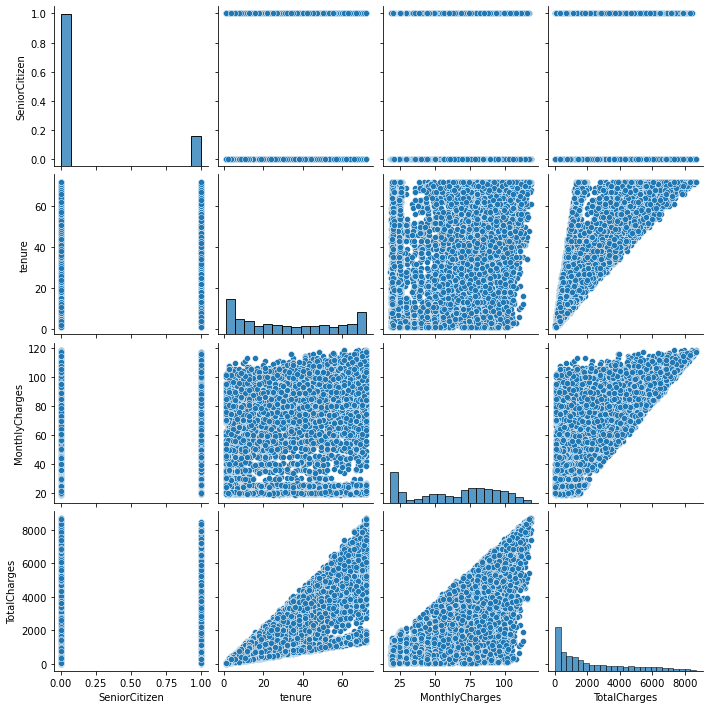

In [7]:
#Draw pairwise features to see correlation - totalcharges correlate with tenure & monthly charges because is cumulative pay over time.
#The longer tenure the more totcharges, the higher monthly the higher total
sns.pairplot(data=df)

In [8]:
#Dummify categorical features & encode ordinal features &encode label

#dummify categorical features
features_dummify=['gender', 'Partner', 'Dependents','PhoneService', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'PaymentMethod']
df=pd.get_dummies(data=df,columns=features_dummify,drop_first=True)

#encode ordinal features 'MultipleLines','Contract

# Define a dictionary for encoding variable
enc_dict = {'No phone service':0,
            'No':1,
            'Yes':2}
# Create the mapped values in a new column
df['MultipleLines'] = df['MultipleLines'].map(enc_dict)

# Define a dictionary for encoding variable
enc_dict = {'Month-to-month':0,
            'One year':1,
            'Two year':2}
# Create the mapped values in a new column
df['Contract'] = df['Contract'].map(enc_dict)


from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['Churn_enc']=le.fit_transform(df['Churn'])
df.drop('Churn',axis=1,inplace=True)

In [9]:
# Let's do correlation check after dummification & encoding
# Monthly charges, TotalCharges has strong correlation with extra features (which makes sense you pay more for extra features)
# Some features seem interwinde for example if someone doesn't have internet than has no streaming, online protection etc. 
corr=df.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Users\User\AppData\Local\Temp/ipykernel_5504/2564116846.py:8: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr


In [10]:
#Top 10 correlations (positive & negative)
corr=df.corr()
display(corr['Churn_enc'].sort_values(ascending=False).head(5))
display(corr['Churn_enc'].sort_values(ascending=False).tail(5))

Churn_enc                         1.000000
InternetService_Fiber optic       0.307463
PaymentMethod_Electronic check    0.301455
MonthlyCharges                    0.192858
PaperlessBilling_Yes              0.191454
Name: Churn_enc, dtype: float64

TechSupport_No internet service        -0.227578
DeviceProtection_No internet service   -0.227578
OnlineBackup_No internet service       -0.227578
tenure                                 -0.354049
Contract                               -0.396150
Name: Churn_enc, dtype: float64

In [11]:
X=df.drop(['Churn_enc'],axis=1)
y=df['Churn_enc']

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=2021,train_size=0.6)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, random_state=2021,train_size=0.5)

print('Train shape', X_train.shape,y_train.shape)
print('Val shape', X_val.shape,y_val.shape)
print('Val shape', X_test.shape,y_test.shape)

Train shape (4219, 28) (4219,)
Val shape (1407, 28) (1407,)
Val shape (1406, 28) (1406,)


In [13]:
#Calculate class wieghts
from sklearn.utils import class_weight

class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

array([0.68099942, 1.8812199 ])

In [14]:
#Normalizacja features (uwaga na val i test robimy tylko transorm symulujac ze to nowe dane w ten sposob)

#To samo odchylenie
sc=StandardScaler()
X_train=pd.DataFrame(data=sc.fit_transform(X_train),columns=X_train.columns)
X_val=pd.DataFrame(data=sc.transform(X_val),columns=X_val.columns)
X_test=pd.DataFrame(data=sc.transform(X_test),columns=X_test.columns)

#Ten sam max i imin
sc=MinMaxScaler()
X_train=pd.DataFrame(data=sc.fit_transform(X_train),columns=X_train.columns)
X_val=pd.DataFrame(data=sc.transform(X_val),columns=X_val.columns)
X_test=pd.DataFrame(data=sc.transform(X_test),columns=X_test.columns)

In [22]:
X_train=X_train[['Contract','tenure','InternetService_Fiber optic','PaymentMethod_Electronic check','TechSupport_No internet service','DeviceProtection_No internet service','OnlineBackup_No internet service']]
X_val=X_val[['Contract','tenure','InternetService_Fiber optic','PaymentMethod_Electronic check','TechSupport_No internet service','DeviceProtection_No internet service','OnlineBackup_No internet service']]

<H1>Lets see results for different models<H1>

In [23]:
#Lets see the results for different classification models (hyperparameters taken randomly)

from sklearn.linear_model  import LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)
pred_train=model.predict(X_train)
pred_val=model.predict(X_val)

print("Logistic Regression")
return_metrics()

Logistic Regression


TP     FP     FN     TN       AUC  Accuracy  Precision    Recall  \
Train  2788.0  303.0  582.0  546.0  0.693008  0.790235    0.64311  0.484043   
Val     923.0  103.0  192.0  189.0  0.697837  0.790334    0.64726  0.496063   

             F1  
Train  0.552352  
Val    0.561664

In [24]:
from sklearn.naive_bayes  import GaussianNB
model=GaussianNB()
model.fit(X_train,y_train)
pred_train=model.predict(X_train)
pred_val=model.predict(X_val)

print("Naive Bayes")
return_metrics()

Naive Bayes


TP      FP     FN     TN       AUC  Accuracy  Precision    Recall  \
Train  1887.0  1204.0  151.0  977.0  0.738308  0.678834   0.447960  0.866135   
Val     640.0   386.0   61.0  320.0  0.731838  0.682303   0.453258  0.839895   

             F1  
Train  0.590511  
Val    0.588776

In [25]:
from sklearn.linear_model  import SGDClassifier
model=SGDClassifier(loss='modified_huber',shuffle=True,random_state=2021)
model.fit(X_train,y_train)
pred_train=model.predict(X_train)
pred_val=model.predict(X_val)

print("Stochastic Gradient Boost")
return_metrics()

Stochastic Gradient Boost


TP     FP     FN     TN       AUC  Accuracy  Precision    Recall  \
Train  2469.0  622.0  357.0  771.0  0.741141  0.767954   0.553482  0.683511   
Val     821.0  205.0  119.0  262.0  0.743929  0.769723   0.561028  0.687664   

             F1  
Train  0.611662  
Val    0.617925

In [18]:
from sklearn.neighbors  import KNeighborsClassifier
model=KNeighborsClassifier()
model.fit(X_train,y_train)
pred_train=model.predict(X_train)
pred_val=model.predict(X_val)

print("K Neigbors")
return_metrics()

K Neigbors


TP     FP     FN     TN       AUC  Accuracy  Precision    Recall  \
Train  2782.0  309.0  382.0  746.0  0.780690  0.836217   0.707109  0.661348   
Val     870.0  156.0  193.0  188.0  0.670696  0.751955   0.546512  0.493438   

             F1  
Train  0.683463  
Val    0.518621

In [26]:
from sklearn.tree  import DecisionTreeClassifier
model=DecisionTreeClassifier(max_depth=10,min_samples_leaf=15)
model.fit(X_train,y_train)
pred_train=model.predict(X_train)
pred_val=model.predict(X_val)

print("Decision Tree")
return_metrics()

Decision Tree


TP     FP     FN     TN       AUC  Accuracy  Precision    Recall  \
Train  2720.0  371.0  449.0  679.0  0.740962  0.805641   0.646667  0.601950   
Val     887.0  139.0  180.0  201.0  0.696041  0.773276   0.591176  0.527559   

             F1  
Train  0.623508  
Val    0.557559

In [27]:
from sklearn.ensemble  import RandomForestClassifier
model=RandomForestClassifier(max_depth=10,min_samples_leaf=15,random_state=2021)
model.fit(X_train,y_train)
pred_train=model.predict(X_train)
pred_val=model.predict(X_val)

print("Random Forrest")
return_metrics()

Random Forrest


TP     FP     FN     TN       AUC  Accuracy  Precision    Recall  \
Train  2716.0  375.0  456.0  672.0  0.737212  0.803034   0.641834  0.595745   
Val     897.0  129.0  173.0  208.0  0.710100  0.785359   0.617211  0.545932   

             F1  
Train  0.617931  
Val    0.579387

In [28]:
from sklearn.svm  import SVC
model=SVC(kernel='linear', C=0.025)
model.fit(X_train,y_train)
pred_train=model.predict(X_train)
pred_val=model.predict(X_val)

print("Support Vector Machine")
return_metrics()

Support Vector Machine


TP     FP     FN     TN       AUC  Accuracy  Precision    Recall  \
Train  2767.0  324.0  558.0  570.0  0.700249  0.790946   0.637584  0.505319   
Val     913.0  113.0  185.0  196.0  0.702150  0.788202   0.634304  0.514436   

             F1  
Train  0.563798  
Val    0.568116

<H1>Let's try to find best hyperparameters for random forest classifier<H1>

In [99]:
#Try to find bets params for random forest
model=RandomForestClassifier()
param_list={
    "max_depth": [2,3,4,5,6,7,8,9,10,11,12,13,14,15,20],
    "min_samples_leaf": [5,10,15,20,30],
    # "max_features": ['auto', 'sqrt', 'log2'],
    # "oob_score": ['False','true'],
    "class_weight": [{0:0.68099942,1:1.8812199}]
}

gs=GridSearchCV(model,param_list,cv=5,n_jobs=-1,scoring="f1_weighted")
gs.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.68099942, 1: 1.8812199}],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 20],
                         'min_samples_leaf': [5, 10, 15, 20, 30]},
             scoring='f1_weighted')

In [100]:
gs.best_params_

{'class_weight': {0: 0.68099942, 1: 1.8812199},
 'max_depth': 14,
 'min_samples_leaf': 5}

In [79]:
# Display the best params & also display results
display(gs.best_params_)
pd.DataFrame(gs.cv_results_)[['params','mean_test_score','std_test_score','rank_test_score']].sort_values('rank_test_score')

{'class_weight': {0: 1, 1: 3}, 'max_depth': 20, 'min_samples_leaf': 5}

params  mean_test_score  \
70  {'class_weight': {0: 1, 1: 3}, 'max_depth': 20...         0.782978   
65  {'class_weight': {0: 1, 1: 3}, 'max_depth': 15...         0.781976   
55  {'class_weight': {0: 1, 1: 3}, 'max_depth': 13...         0.780671   
60  {'class_weight': {0: 1, 1: 3}, 'max_depth': 14...         0.780661   
50  {'class_weight': {0: 1, 1: 3}, 'max_depth': 12...         0.780447   
..                                                ...              ...   
0   {'class_weight': {0: 1, 1: 3}, 'max_depth': 2,...         0.729890   
1   {'class_weight': {0: 1, 1: 3}, 'max_depth': 2,...         0.728158   
2   {'class_weight': {0: 1, 1: 3}, 'max_depth': 2,...         0.727271   
4   {'class_weight': {0: 1, 1: 3}, 'max_depth': 2,...         0.726444   
3   {'class_weight': {0: 1, 1: 3}, 'max_depth': 2,...         0.722669   

    std_test_score  rank_test_score  
70        0.006760                1  
65        0.011556                2  
55        0.010666                3  
60        0.010458                4  
50        0.009492                5  
..             ...              ...  
0         0.018483               71  
1         0.016189               72  
2         0.015731               73  
4         0.015031               74  
3         0.018268               75  

[75 rows x 4 columns]

In [101]:
#train on best params and print reports
rf = RandomForestClassifier(**gs.best_params_)
rf.fit(X_train,y_train)
pred_train=rf.predict(X_train)
pred_val=rf.predict(X_val)

print(classification_report(pred_train,y_train))
print(classification_report(pred_val,y_val))

# pd.DataFrame(data=rf.feature_importances_,columns=X.columns)
rf.feature_importances_

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      2759
           1       0.87      0.67      0.76      1460

    accuracy                           0.85      4219
   macro avg       0.86      0.81      0.82      4219
weighted avg       0.85      0.85      0.85      4219

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       923
           1       0.72      0.57      0.63       484

    accuracy                           0.77      1407
   macro avg       0.76      0.73      0.74      1407
weighted avg       0.77      0.77      0.77      1407



array([0.01166184, 0.16606231, 0.0159098 , 0.16165831, 0.10069804,
       0.14176782, 0.01608636, 0.0137813 , 0.01353215, 0.00430071,
       0.06208339, 0.01225956, 0.01643222, 0.03316271, 0.02067959,
       0.01263807, 0.01972143, 0.01110981, 0.01052236, 0.02929264,
       0.01700981, 0.0122866 , 0.0089757 , 0.01143811, 0.01560511,
       0.00963589, 0.04326547, 0.00842287])

In [16]:
#function that print test & val metrics (hardcoded need to change to better coding)
def return_metrics():
    train_res=confusion_matrix(y_train,pred_train)
    val_res=confusion_matrix(y_val,pred_val)
    TP=[train_res[0,0],val_res[0,0]]
    FP=[train_res[0,1],val_res[0,1]]
    FN=[train_res[1,0],val_res[1,0]]
    TN=[train_res[1,1],val_res[1,1]]
    accuracy_=[accuracy_score(y_train,pred_train),accuracy_score(y_val,pred_val)]
    precision_=[precision_score(y_train,pred_train),precision_score(y_val,pred_val)]
    recall_=[recall_score(y_train,pred_train),recall_score(y_val,pred_val)]
    f1_=[f1_score(y_train,pred_train),f1_score(y_val,pred_val)]
    roc_auc_=[roc_auc_score(y_train,pred_train),roc_auc_score(y_val,pred_val)]
    res=pd.DataFrame([TP,FP,FN,TN,roc_auc_,accuracy_,precision_,recall_,f1_],index=['TP','FP','FN','TN','AUC','Accuracy','Precision','Recall','F1'],columns=['Train','Val'])
    # res=res.pivot(data=res,columns=res.index,index=res.columns)
    return res.transpose()

In [72]:
return_metrics()

TP     FP     FN     TN       AUC  Accuracy  Precision    Recall  \
Train  2594.0  497.0  134.0  994.0  0.860208  0.850438   0.666667  0.881206   
Val     805.0  221.0  102.0  279.0  0.758442  0.770434   0.558000  0.732283   

             F1  
Train  0.759068  
Val    0.633371

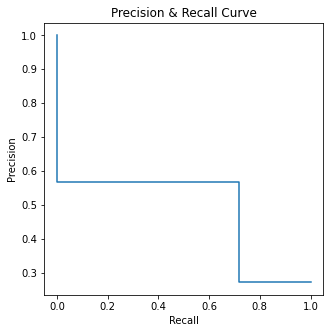

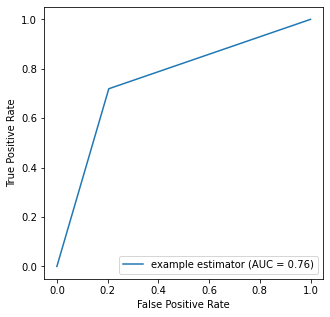

In [104]:
#Lets see precision / recall & ROC curves. First one should better measure for imbalanced set as we have it. 
from sklearn.metrics import precision_recall_curve,PrecisionRecallDisplay,roc_curve,auc,RocCurveDisplay

plt.rcParams["figure.figsize"] = (5,5) 

precision, recall, _ = precision_recall_curve(y_val, pred_val)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot() 
plt.title('Precision & Recall Curve')
plt.show()

#AUC ROC curve
fpr, tpr, thresholds = roc_curve(y_val, pred_val)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()


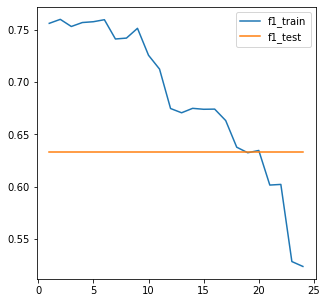

In [105]:
#Reduce number of features by calculating how much of y variance is explained by X variance and setting a treshold
from sklearn.feature_selection import VarianceThreshold
 
def selectionVarianceThreshold(df, variance_threshold=0.0):
    sel = VarianceThreshold(threshold=variance_threshold)
    sel_var=sel.fit_transform(df)
    sel_loc_index = sel.get_support(indices=True)
 
    if len(sel_loc_index)==0:
        return None
    else: 
        return list(df.columns[sel_loc_index])


#Loop that will calculate f1 result depending on variabality explain treshold of X. 
# Essentially it takes columns that have variability bigger than given (note they are divided by 100) and trains model & evaluates it
f1_train=[]
f1_test=[]

for  i in range(1,25,1):
    feats_to_include_VT = selectionVarianceThreshold(X_train, 
                        variance_threshold=i/100)
    rf.fit(X_train[feats_to_include_VT],y_train)
    pred_train=rf.predict(X_train[feats_to_include_VT])
    pred_test=rf.predict(X_test[feats_to_include_VT])
    f1_train.append(f1_score(y_train,pred_train))
    f1_test.append(f1_score(y_val,pred_val))

#draw results of above plot
plt.plot(range(1,25,1),f1_train,label='f1_train')
plt.plot(range(1,25,1),f1_test,label='f1_test')
plt.legend()
plt.show()


In [110]:
#Lets explore how hyperparameters values impact train & test results
param_ = [2,4,6,8,10,11,13,15,17,20,30]

train_scores, test_scores = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'min_samples_leaf', 
                                param_range = param_, cv = 3,n_jobs=-1,scoring='f1_weighted')

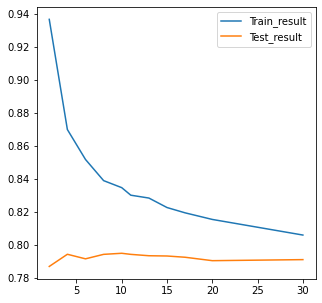

In [111]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.plot(param_,train_scores_mean,label='Train_result')
plt.plot(param_,test_scores_mean,label='Test_result')
plt.legend()
plt.show()

# plt.title("Validation Curve with SVM")
# plt.xlabel(r"$\gamma$")
# plt.ylabel("Score")
# plt.ylim(0.0, 1.1)
# lw = 2
# plt.semilogx(
#     param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
# )
# plt.fill_between(
#     param_range,
#     train_scores_mean - train_scores_std,
#     train_scores_mean + train_scores_std,
#     alpha=0.2,
#     color="darkorange",
#     lw=lw,
# )
# plt.semilogx(
#     param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
# )
# plt.fill_between(
#     param_range,
#     test_scores_mean - test_scores_std,
#     test_scores_mean + test_scores_std,
#     alpha=0.2,
#     color="navy",
#     lw=lw,
# )
# plt.legend(loc="best")
# plt.show()